In [1]:
import os
import sys
sys.path.insert(0,os.path.join('/project/venv/vit_xai/lib/python3.8/site-packages/'))

In [2]:
!nvidia-smi

Tue Aug 20 08:08:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:3D:00.0 Off |                  N/A |
|  0%   21C    P8               1W / 250W |   9983MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

# Import libraries

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from transformers import TFViTForImageClassification, ViTImageProcessor
import tensorflow as tf
from datasets import load_dataset
from skimage.util import view_as_blocks
from numpy.linalg import norm

2024-08-20 08:08:30.503460: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 08:08:30.549162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load data

In [5]:
val_data = load_dataset("frgfm/imagenette", "full_size", trust_remote_code=True,split='validation')

In [6]:
val_data.shuffle()

Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

# Get concepts

In [7]:
concepts = [[],[],[],[],[],[],[],[],[],[]]
labels = []
n_examples = 20

for item in val_data:
    if np.array(item['image']).shape[-1]==3: # only look at images with 3 channels
        if (item['label']==0) & (len(concepts[0])<n_examples): #"tench"       # get the correct label
            labels.append(0)
            concepts[0].append([np.array(item['image']),item['label']])
        elif (item['label']==1) & (len(concepts[1])<n_examples): #"English springer"
            labels.append(217)
            concepts[1].append([np.array(item['image']),item['label']])
        elif (item['label']==2) & (len(concepts[2])<n_examples): #"cassette player"
            labels.append(482)
            concepts[2].append([np.array(item['image']),item['label']])
        elif (item['label']==3) & (len(concepts[3])<n_examples): #"chain saw"
            labels.append(491)
            concepts[3].append([np.array(item['image']),item['label']])
        elif (item['label']==4) & (len(concepts[4])<n_examples): #"church"
            labels.append(497)
            concepts[4].append([np.array(item['image']),item['label']])
        elif (item['label']==5) & (len(concepts[5])<n_examples): #"French horn"
            labels.append(566)
            concepts[5].append([np.array(item['image']),item['label']])
        elif (item['label']==6) & (len(concepts[6])<n_examples): #"garbage truck"
            labels.append(569)
            concepts[6].append([np.array(item['image']),item['label']])
        elif (item['label']==7) & (len(concepts[7])<n_examples): # "gas pump"
            labels.append(571)
            concepts[7].append([np.array(item['image']),item['label']])
        elif (item['label']==8) & (len(concepts[8])<n_examples): # "golf ball"
            labels.append(574)
            concepts[8].append([np.array(item['image']),item['label']])
        elif (item['label']==9) & (len(concepts[9])<n_examples): #"parachute"
            labels.append(701)
            concepts[9].append([np.array(item['image']),item['label']])

In [8]:
def print_examples(concept):
  for i in range(0,5):
    plt.subplot(1,5,i+1)
    plt.imshow(concept[i][0])
    plt.axis("off")

  plt.tight_layout()
  plt.show()

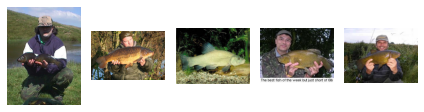

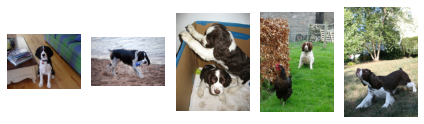

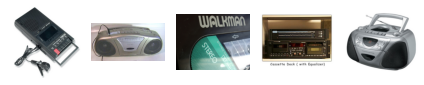

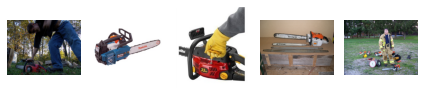

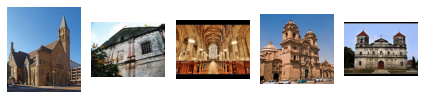

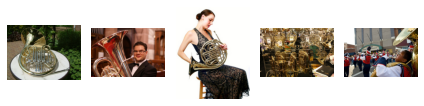

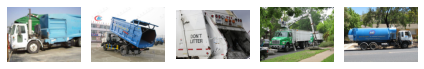

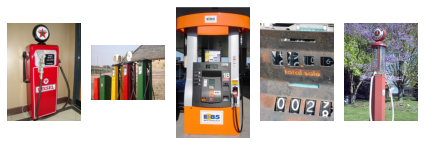

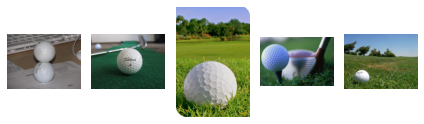

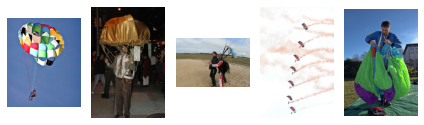

In [9]:
# for each class take the first n_examples images to form concept
for concept in concepts:
    print_examples(concept[:5])

# Load pretrained model

In [10]:
model = TFViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

image_processor = ViTImageProcessor()

2024-08-20 08:08:52.430603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9803 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5
All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [11]:
model.summary(expand_nested=True)

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  769000    
                                                                 
Total params: 86567656 (330.23 MB)
Trainable params: 86567656 (330.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
print(model.config)

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
    "15": "robin, American robin, Turdus migratorius",
    "16": "bulbul",
 

# Concept embeddings

In [13]:
#  average the embedding for a concept -> concept embedding
def average_embedding(embedding):
    embedding = embedding.numpy() # (20, 197, 768)
    embedding = embedding[:,1:,:] # drop CLS -> (20, 196, 768)
    embedding = embedding.mean(axis=0) # mean over batch
    embedding = embedding.mean(axis=0) # mean over patches
    # embedding (768,)
    
    return embedding

# embedding of one example image of a concept
def image_embedding(embedding):
    embedding = embedding.numpy() # (197, 768)
    embedding = embedding[1:,:] # drop CLS -> (196, 768)
    embedding = embedding.mean(axis=0) # mean over patches
    # embedding (768,)
    
    return embedding


# average the embedding for a concept -> concept embedding, only using k most relevant patches
def average_embedding_top_k(embedding, k, relevances, modus):
    # embedding (20, 197, 768) 
    # relevances  (20,196)
    
    avg = []
    for i, relevance in enumerate(relevances): # relevance: (196,) -> relevances are for all examples of a concept; i--> ith image of a concept
        # take only k most important patches
        if modus == "top": # normal top-k selection
            _, indices = tf.math.top_k(relevance, k=k, sorted=True)
        elif modus == "bottom": # flipped top-k selection
            _, indices = tf.math.top_k(-1*relevance, k=k, sorted=True)
        elif modus == "random": # random selection
            indices = tf.random.uniform(shape=(30,), minval=0,maxval=195, dtype=tf.int64)
        else:
            raise "Modus not supported"
        
        indices = indices.numpy() # (30,)
        intermediate = embedding[i,1:,:].numpy() # (197, 768) # take embedding of ith example corresponding to relevance, remove CLS
        intermediate = tf.gather(intermediate, indices).numpy() # take only top-k patches -> (30, 768)
        intermediate = np.array(intermediate.mean(axis=0)) # mean over patches -> (768,)
        avg.append(intermediate)  # avg embedding of image
    avg = np.array(avg).mean(axis=0) # mean over examples (20, 768) -> (768,) avg embedding of whole concept

    return avg

# embedding of one example image of a concept only using top k most relevant patches
def image_embedding_top_k(embedding, k, relevances, modus):
    # embedding (197, 768) 
    # relevances  (196)
    
    # take only k most important patches
    if modus == "top": # normal top-k selection
        _, indices = tf.math.top_k(relevances, k=k, sorted=True)
    elif modus == "bottom": # flipped top-k selection
        _, indices = tf.math.top_k(-1*relevances, k=k, sorted=True)
    elif modus == "random": # random selection
        indices = tf.random.uniform(shape=(30,), minval=0,maxval=195, dtype=tf.int64)
    else:
        raise "Modus not supported"
        
    indices = indices.numpy() # (30,)
    intermediate = embedding[1:,:].numpy() # (197, 768) #  remove CLS
    intermediate = tf.gather(intermediate, indices).numpy() # take only top-k patches -> (30, 768)
    intermediate = np.array(intermediate.mean(axis=0)) # mean over patches -> (768,)
    
    return intermediate

In [14]:
def get_embeddings_and_attentions(concepts_selected):
    # Get Input for the model wrt different concepts
    inputs = []
    for concept in concepts_selected:
        x_concept,_ = zip(*concept)
        inputs.append(image_processor(x_concept, return_tensors="tf").pixel_values)

    # make predictions
    preds = []
    for input in inputs:
        pred = model(input, output_hidden_states=True, output_attentions=True)
        preds.append(pred)


    # for each concept in concept_nums(4): for each layer (13): (20,197,768)
    embeddings_list = []
    # for each concept in concept_nums(4): for each layer (12): (20,12,197,197)
    attentions_list = []
    for pred in preds:
        embeddings_list.append(pred.hidden_states)
        attentions_list.append(pred.attentions)
        
    return embeddings_list, attentions_list


def get_embeddings(concepts):
    # Get Input for the model wrt different concepts
    inputs = []
    for concept in concepts:
        x_concept,_ = zip(*concept)
        inputs.append(image_processor(x_concept, return_tensors="tf").pixel_values)

    # make predictions
    preds = []
    for input in inputs:
        pred = model(input, output_hidden_states=True, output_attentions=True)
        preds.append(pred)


    # for each concept in concept_nums(4): for each layer (13): (20,197,768)
    embeddings_list = []

    for pred in preds:
        embeddings_list.append(pred.hidden_states)
        
    return embeddings_list

## Patch selection

### Attention Rollout

In [15]:
#https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py

def rollout(attentions, discard_ratio, head_fusion, layer_num):
  # attentions: for 12 layers: (20, 12, 197, 197) = (batch_size, n_heads, sequence_len, sequence_len)
  result = tf.eye(attentions[0].shape[-1]) # result.shape=(197,197), attentions[0].shape (1, 12, 197, 197)
  for i, attention in enumerate(attentions[::-1]):
    if i + layer_num == 12: # do rollout only until specified layer ------------------- 
        break
    if head_fusion == "mean":
      attention_heads_fused = attention.numpy().mean(axis=1)
    elif head_fusion == "max":
      attention_heads_fused = attention.numpy().max(axis=1)[0]
    elif head_fusion == "min":
      attention_heads_fused = attention.numpy().min(axis=1)#[0]
    else:
      raise "Attention head fusion type Not supported"

    # attention_heads_fused.shape -> (1,197,197)

    # Drop the lowest attentions, but
    # don't drop the class token
    flat = attention_heads_fused.reshape(attention_heads_fused.shape[0], -1) # flat.shape -> (1, 38809)
    _, indices = tf.math.top_k(flat, k=int(flat.shape[-1]*discard_ratio), sorted=False)
    indices = indices[indices != 0]
    flat[0, indices] = 0

    I = tf.eye(attention_heads_fused.shape[-1]) #I.shape -> (197,197)
    a = (attention_heads_fused + 1.0*I)/2
    a = a / tf.math.reduce_sum(a, -1)

    result = tf.matmul(a, result) # (1,197,197)

  # Look at the total attention between the class token,
  # and the image patches
  #print(result.shape)
  mask = result[0,0,1:]
    
  return mask.numpy()

In [16]:
class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="max",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        #for name, module in self.model.named_modules():
           # if attention_layer_name in name:
               # module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor, layer_num):
        self.attentions = []
        output = self.model(input_tensor, output_attentions=True)

        return rollout(output.attentions, self.discard_ratio, self.head_fusion, layer_num)

### Relevances

#### Attention relevance - Class token in different layers

In [17]:
# ignore this for now
def get_attention_relevance_multiple_concepts(concepts_selected, attentions_list, layer_num):
    relevances_list = []
    ### basic attention: CLS at different layers

    for i in range(len(concepts_selected)):
        # for each concept: attention of  layer [0,11], mean over heads
        att = attentions_list[i][layer_num].numpy().mean(axis=1)  # (20, 12, 197, 197) -> (20, 197, 197)
        # attention from CLS token to all other patches
        relevances_list.append(att[:,0,1:])
    return relevances_list


def get_attention_relevance(attentions, layer_num):
    # attentions --> (12, 20, 12, 197, 197) - attentions of all 20 images of a concept, across 12 layers, 12 heads, 197 tokens

    # basic attention: CLS at different layers
    # for each concept: attention of layer [0,11], mean over heads
    ## attentions[layer_num].numpy() --> extracting attention of a layer: (12, 20, 12, 197, 197) -> (20, 12, 197, 197)
    ## taking mean attention over all heads: (20, 12, 197, 197) -> (20, 197, 197
    att = attentions[layer_num].numpy().mean(axis=1)
    # attention from CLS token to all other patches
    att = att[:,0,1:] # Shape: (20, 196)
    
    return att # (20,196)



#### Attention relevance - Class token in different layers (with rollout)

In [18]:
# ignore this for now
def get_rollout_relevance_multiple_concepts(concepts_selected, inputs, model, layer_num):
    grad_rollout = VITAttentionRollout(model, head_fusion="mean", discard_ratio=0.01)

      # for each concept: for each example (20):  196 relevance values
    masks_list = []

    for input in inputs:
        masks = []
        for i in range(len(concepts_selected[0])):
            mask = grad_rollout(input[i:i+1], layer_num)   # (196,)
            masks.append(mask)
        masks_list.append(masks)

    return masks_list

def get_rollout_relevance(concept, model, layer_num):
    grad_rollout = VITAttentionRollout(model, head_fusion="mean", discard_ratio=0.01)
    x_concept,_ = zip(*concept)
    input = image_processor(x_concept, return_tensors="tf").pixel_values

    # for each example (20):  196 relevance values
    masks = []
    for i in range(len(concept)):
        mask = grad_rollout(input[i:i+1], layer_num)   # (196,)
        masks.append(mask)

    return masks

#### Attention relevance - Aggregated attention in different layers

In [19]:
def get_agg_attention_relevance(attentions_list, layer_num, aggregation_type='max'):
    # attentions_list --> (12, 20, 12, 197, 197) - attentions of all 20 images of a concept, across 12 layers, 12 heads, 197 tokens
    # aggregation types (max, min, mean)

    # Extract the attentions for the specific layer
    layer_attentions = attentions_list[layer_num].numpy()  # Shape: (20, 12, 197, 197)

    # Initialize array to store the attention relevance scores for each image
    agg_attention_relevances = np.zeros((layer_attentions.shape[0], layer_attentions.shape[2] - 1))  # Shape: (20, 196)

    # Iterate over each image in the batch
    for i in range(layer_attentions.shape[0]):
        # Extract the attention values for the current image, excluding the CLS token
        image_attentions = layer_attentions[i, :, 1:, 1:]  # Shape: (12, 196, 196) - 12 heads, 196 tokens (excluding CLS), 196 tokens (excluding CLS)

        # Calculate the aggregated attention over all heads for each token (excluding CLS token)
        # First, take the aggregated attention across the heads
        # Then, take the aggregated attention attention value for each token
        if aggregation_type == 'max':
            # Calculate the maximum attention over all heads for each token (excluding CLS token)
            max_attention_across_heads = np.max(image_attentions, axis=0)  # Shape after max across heads: (196, 196)
            agg_attention_relevance = np.max(max_attention_across_heads, axis=1)  # Shape after max across tokens: (196,)
        elif aggregation_type == 'min':
            # Calculate the minimum attention over all heads for each token (excluding CLS token)
            min_attention_across_heads = np.min(image_attentions, axis=0)  # Shape after min across heads: (196, 196)
            agg_attention_relevance = np.min(min_attention_across_heads, axis=1)  # Shape after min across tokens: (196,)
        elif aggregation_type == 'mean':
            # Calculate the mean attention over all heads for each token (excluding CLS token)
            mean_attention_across_heads = np.mean(image_attentions, axis=0)  # Shape after mean across heads: (196, 196)
            agg_attention_relevance = np.mean(mean_attention_across_heads, axis=1)  # Shape after mean across tokens: (196,)
        else:
            raise ValueError(f"Unsupported aggregation type: {aggregation_type}")

        # Store the relevance scores for the current image
        agg_attention_relevances[i] = agg_attention_relevance

    return agg_attention_relevances  # Shape: (20, 196)

#### Gradient relevance

In [20]:
def get_gradient_relevance_per_image(example, layer_num):
    input = image_processor(example, return_tensors="tf").pixel_values

    with tf.GradientTape() as tape:
        tape.watch(input)
        preds = model(input, output_hidden_states=True)

    #get gradient w.r.t patch embeddings
    grads = tape.gradient(preds.logits, preds.hidden_states[layer_num])
    grads = np.array(grads)
    grads = np.where(grads >= 0, grads, 0) # (1,197,768)
    
    grads = grads.mean(axis=-1) # mean over 768 values -> avg. gradient for a patch (1,197)


    return grads[0,1:] # remove CLS token


def get_gradient_relevance(concept, layer_num):
    x_concept,_ = zip(*concept)
    
    grads_list = []
    
    for i in range(len(x_concept)):
        grads_list.append(get_gradient_relevance_per_image(x_concept[i], layer_num))
    
    return grads_list


#### Embedding relevance

In [21]:
def get_embedding_relevance(embeddings_list, layer_num):
    # embeddings_list --> (13, 20, 197, 768) - embeddings of all 20 images of a concept, across 13 layers

    # Extract the embeddings for the specific layer
    layer_embeddings = embeddings_list[layer_num].numpy()  # Shape: (20, 197, 768)

    # Initialize arrays to store the relevance scores for each image
    embedding_relevances = np.zeros((layer_embeddings.shape[0], layer_embeddings.shape[1] - 1))  # Shape: (20, 196)

    # Iterate over each image in the batch
    for i in range(layer_embeddings.shape[0]): # each image - (197, 768)
        # Exclude the CLS token (first token) and calculate the maximum of the absolute values of the 768 embedding values for each token
        max_abs_768emb_196tokens = np.max(np.abs(layer_embeddings[i, 1:, :]), axis=1)  # Shape: (196,)

        # Store the relevance scores
        embedding_relevances[i] = max_abs_768emb_196tokens

    return embedding_relevances # Shape: (20, 196)

# Choosing the "best" k 

## Get relevant patches

In [22]:
embeddings_list, attentions_list = get_embeddings_and_attentions(concepts)

2024-08-20 08:08:56.154071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700


In [23]:
layer_num = 0
k_list = [1,2,4,8,16,32,64,128,196]

indices_concepts_list_attention_all = []
indices_concepts_list_rollout_all = []
indices_concepts_list_gradient_all = []
indices_concepts_list_agg_attention_all = []
indices_concepts_list_embedding1_all = []

for k in k_list:

    indices_concepts_list_attention = []
    indices_concepts_list_rollout = []
    indices_concepts_list_gradient = []
    indices_concepts_list_agg_attention = []
    indices_concepts_list_embedding1 = []

    for concept_num in range(len(concepts)):  
        # for each concept, get the different kinds of relevances
        relevances_attention = get_attention_relevance(attentions_list[concept_num], layer_num)
        relevances_rollout = get_rollout_relevance(concepts[concept_num], model, layer_num)
        relevances_gradient = get_gradient_relevance(concepts[concept_num], layer_num) 
        relevances_agg_attention = get_agg_attention_relevance(attentions_list[concept_num], layer_num, aggregation_type = 'max') # Shape: (20, 196)
        relevances_embedding1 = get_embedding_relevance(embeddings_list[concept_num], layer_num)

        indices_concept_attention = []
        indices_concept_rollout = []
        indices_concept_gradient = []
        indices_concept_agg_attention = []
        indices_concept_embedding1 = []

        # get the indices of the relevant patches per image
        for i in range(len(concepts[0])): # relevance: (196,) -> relevances are for all examples of a concept; i--> ith image of a concept
            # take only k most important patches
            _, indices_attention = tf.math.top_k(relevances_attention[i], k=k, sorted=True)
            _, indices_rollout = tf.math.top_k(relevances_rollout[i], k=k, sorted=True)
            _, indices_gradient = tf.math.top_k(relevances_gradient[i], k=k, sorted=True)
            _, indices_agg_attention = tf.math.top_k(relevances_agg_attention[i], k=k, sorted=True)
            _, indices_embedding1 = tf.math.top_k(relevances_embedding1[i], k=k, sorted=True)

            indices_one_image_attention = indices_attention.numpy() # (30,)
            indices_one_image_rollout = indices_rollout.numpy() # (30,)
            indices_one_image_gradient = indices_gradient.numpy() # (30,)
            indices_one_image_agg_attention = indices_agg_attention.numpy() # (30,)
            indices_one_image_embedding1 = indices_embedding1.numpy() # (30,)

            indices_concept_attention.append(indices_one_image_attention)
            indices_concept_rollout.append(indices_one_image_rollout)
            indices_concept_gradient.append(indices_one_image_gradient)
            indices_concept_agg_attention.append(indices_one_image_agg_attention)
            indices_concept_embedding1.append(indices_one_image_embedding1)

        indices_concepts_list_attention.append(indices_concept_attention)
        indices_concepts_list_rollout.append(indices_concept_rollout)
        indices_concepts_list_gradient.append(indices_concept_gradient)
        indices_concepts_list_agg_attention.append(indices_concept_agg_attention)
        indices_concepts_list_embedding1.append(indices_concept_embedding1)
        
    indices_concepts_list_attention_all.append(indices_concepts_list_attention)
    indices_concepts_list_rollout_all.append(indices_concepts_list_rollout)
    indices_concepts_list_gradient_all.append(indices_concepts_list_gradient)
    indices_concepts_list_agg_attention_all.append(indices_concepts_list_agg_attention)
    indices_concepts_list_embedding1_all.append(indices_concepts_list_embedding1)

In [24]:
# for 8 values of k: for 10 concepts: for 20 images: k values
indices_concepts_list_rollout_all[8][1][4].shape

(196,)

## Mask the images to only use relevant patches

In [25]:
def mask_img(indices, img):
    # Create a mask of the same size as the image
    mask = np.zeros((224,224), dtype=np.float32)

    # fill masks with ones where the relevant patches are at
    for ind in indices: # go through all indices
        for i in range(16):
            for j in range(16):
                mask[16*(ind//14)+i,16*(ind%14)+j] = 1

    # repeat mask (224,224) -> (224,224,3)
    mask = np.repeat(mask[...,None], 3, axis=-1)

    img = mask * (tf.image.resize(img, [224,224]).numpy())
    
    return img

In [26]:
masked_attention_list = []
masked_rollout_list = []
masked_gradient_list = []
masked_agg_attention_list = []
masked_embedding1_list = []

for k_num in range(len(k_list)): # go through every k value
    masked_k_attention = []
    masked_k_rollout = []
    masked_k_gradient = []
    masked_k_agg_attention = []
    masked_k_embedding1 = []
    for concept_num in range(len(concepts)): # go through every concept
        masked_concept_attention = []
        masked_concept_rollout = []
        masked_concept_gradient = []
        masked_concept_agg_attention = []
        masked_concept_embedding1 = []
        for img_ind in range(len(concepts[0])): # go through every image -> mask 
            masked_img_attention = mask_img(indices_concepts_list_attention_all[k_num][concept_num][img_ind], concepts[concept_num][img_ind][0])
            masked_concept_attention.append(masked_img_attention)
            masked_img_rollout = mask_img(indices_concepts_list_rollout_all[k_num][concept_num][img_ind], concepts[concept_num][img_ind][0])
            masked_concept_rollout.append(masked_img_rollout)
            masked_img_gradient = mask_img(indices_concepts_list_gradient_all[k_num][concept_num][img_ind], concepts[concept_num][img_ind][0])
            masked_concept_gradient.append(masked_img_gradient)
            masked_img_agg_attention = mask_img(indices_concepts_list_agg_attention_all[k_num][concept_num][img_ind], concepts[concept_num][img_ind][0])
            masked_concept_agg_attention.append(masked_img_agg_attention)
            masked_img_embedding1 = mask_img(indices_concepts_list_embedding1_all[k_num][concept_num][img_ind], concepts[concept_num][img_ind][0])
            masked_concept_embedding1.append(masked_img_embedding1)
        masked_k_attention.append(masked_concept_attention)
        masked_k_rollout.append(masked_concept_rollout)
        masked_k_gradient.append(masked_concept_gradient)
        masked_k_agg_attention.append(masked_concept_agg_attention)
        masked_k_embedding1.append(masked_concept_embedding1)
    masked_attention_list.append(masked_k_attention)
    masked_rollout_list.append(masked_k_rollout)
    masked_gradient_list.append(masked_k_gradient)
    masked_agg_attention_list.append(masked_k_agg_attention)
    masked_embedding1_list.append(masked_k_embedding1)
        
        

(-0.5, 223.5, 223.5, -0.5)

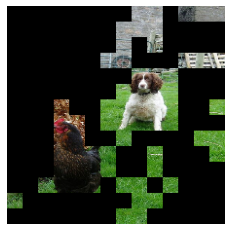

In [38]:
# for every k-value (8): for every concept(10): for every example(20): (224,224,3)
plt.imshow(masked_rollout_list[6][1][3]/255)
plt.axis("off")

In [29]:
np.array(masked_rollout_list[k_num]).reshape(200,224,224,3).shape

(200, 224, 224, 3)

## Evaluate model on masked images

In [30]:
label_numbers = [0,217,482,491,497,566,569,571,574,701]
labels_masked = np.repeat(label_numbers,20)

In [31]:
labels_masked

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 217, 217, 217, 217, 217, 217,
       217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217,
       217, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482,
       482, 482, 482, 482, 482, 482, 482, 482, 491, 491, 491, 491, 491,
       491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491, 491,
       491, 491, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497,
       497, 497, 497, 497, 497, 497, 497, 497, 497, 566, 566, 566, 566,
       566, 566, 566, 566, 566, 566, 566, 566, 566, 566, 566, 566, 566,
       566, 566, 566, 569, 569, 569, 569, 569, 569, 569, 569, 569, 569,
       569, 569, 569, 569, 569, 569, 569, 569, 569, 569, 571, 571, 571,
       571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 571,
       571, 571, 571, 571, 574, 574, 574, 574, 574, 574, 574, 574, 574,
       574, 574, 574, 574, 574, 574, 574, 574, 574, 574, 574, 70

In [32]:
def masked_acc(masked_list, labels_masked, k_list):
    accuracies = []
    for k_num in range(len(k_list)):
        # preprocess masked images [200,3,224,244]  -> 200, because 10 concepts a 20 examples
        inputs = image_processor(np.array(masked_list[k_num]).reshape(200,224,224,3)/255, return_tensors="tf", do_rescale=False, do_resize=False).pixel_values

        # evaluate model on the data
        result = model.evaluate(inputs, labels_masked)
        accuracies.append(result[1]) # add the accuracy to list
    
    return accuracies

In [33]:
model.compile(optimizer="adam", loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

accuracies_attention = masked_acc(masked_attention_list, labels_masked, k_list)
accuracies_rollout = masked_acc(masked_rollout_list, labels_masked, k_list)
accuracies_gradient = masked_acc(masked_gradient_list, labels_masked, k_list)
accuracies_agg_attention = masked_acc(masked_agg_attention_list, labels_masked, k_list)
accuracies_embedding1 = masked_acc(masked_embedding1_list, labels_masked, k_list)



7/7 [==============================] - 1s 169ms/step - loss: 0.3173 - accuracy: 0.8900


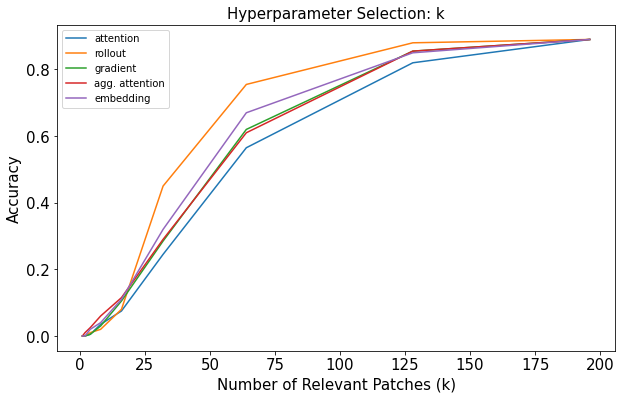

In [34]:
plt.figure(figsize=(10,6))
plt.plot(k_list, accuracies_attention, label="attention")
plt.plot(k_list, accuracies_rollout, label="rollout")
plt.plot(k_list, accuracies_gradient, label="gradient")
plt.plot(k_list, accuracies_agg_attention, label="agg. attention")
plt.plot(k_list, accuracies_embedding1, label="embedding")

plt.xlabel("Number of Relevant Patches (k)", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.yticks(fontsize=15)
plt.title("Hyperparameter Selection: k", fontsize=15)
plt.legend()

plt.show()